## We Have a Problem Statement — Now What? 🤔

Now that we know our goal, let’s take a closer look at the data and see what’s on the menu!

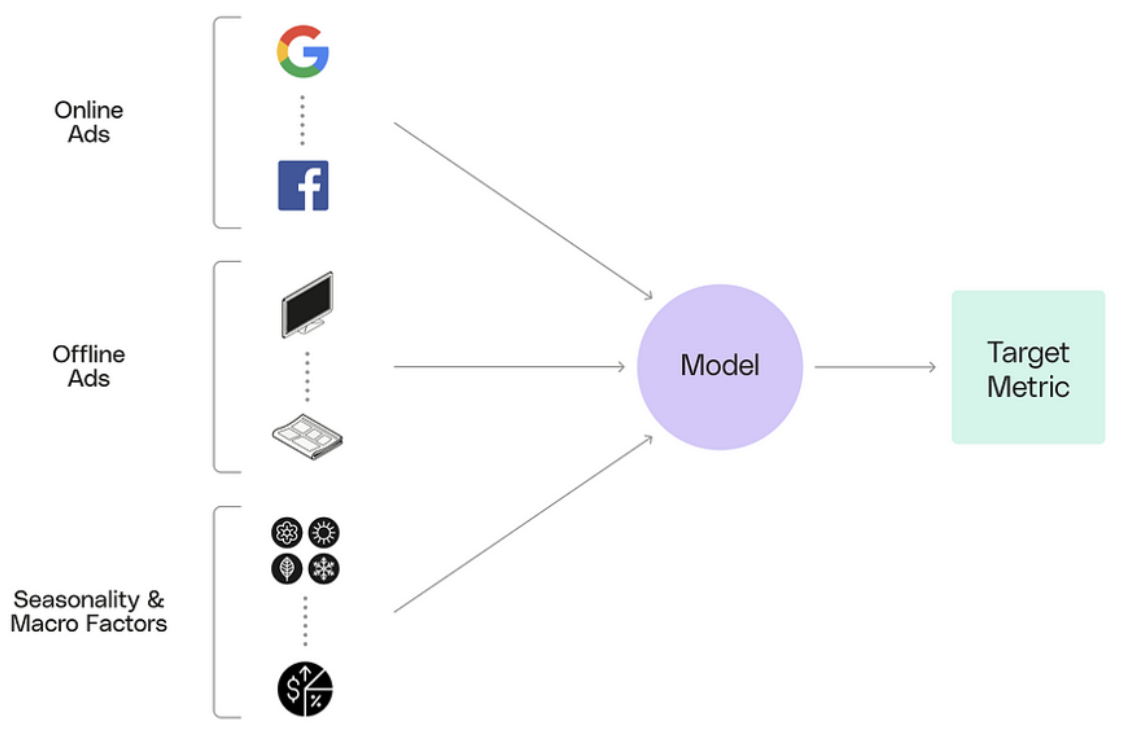

## Read Data & Set Up 🗞


In [1]:
%%capture

!pip install fastexcel
!pip install ipywidgets

In [2]:
from google.colab import auth
import scipy
from datetime import date
import polars as pl
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive
from google.colab import output
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns





output.enable_custom_widget_manager()
pio.templates.default = 'plotly_white'

In [3]:
raw_data_link = "https://docs.google.com/spreadsheets/d/1zUWvOWWT3mUNR3dXXhzJw1-m1RpOpVoQi8x15PpTchM/export?gid=2109606803&format=csv"
df = pl.read_csv(raw_data_link).with_columns(pl.col('week_start').cast(pl.Date))

In [4]:
df.head()

week_start,new_customers,promo_investment,ppc_brand_investment,ppc_generic_investment,facebook_investment,instagram_investment,year,week
date,i64,f64,f64,f64,f64,f64,i64,i64
2020-04-06,678,1489.399629,0.0,291.152796,621.441614,82.890357,2020,15
2020-04-13,172,2017.187355,220.495961,39.978734,388.028088,1246.32403,2020,16
2020-04-20,724,2178.377172,368.822581,605.708988,0.0,1969.201111,2020,17
2020-04-27,834,2412.777908,253.126157,2300.295763,520.649261,2889.605271,2020,18
2020-05-04,939,3441.950338,19.674524,4268.329032,999.081772,4303.434984,2020,19


**Dataframe Description** 🖊

We have a dataframe containing the weekly marketing investment expenditures and the number of new customer acquired.

- week_start: The start of the week (Monday) for each record.
- new_customers: The total number of new customers acquired during the given week.
- promo_investment €: The amount spent on promotions specifically targeted at new customers.
- ppc_brand_investment €: The weekly spend on brand-specific pay-per-click (PPC) advertising campaigns.
- ppc_generic_investment €: The weekly spend on generic PPC advertising campaigns.
- facebook_investment €: The amount spent on Facebook advertising during the week.
- instagram_investment €: The amount spent on Instagram advertising during the week.

PPC campaigns are online ads where advertisers pay per click. The ads can target brand-related searches, used to capture existing brand interest and prevent competitor hijacking; or they can target general product searches, designed to attract new customers unfamiliar with the brand. Meanwhile, investing in Facebook or Instagram advertising means allocating a budget to promote content on the social.


## A Quality Check 👌

- does the dataset contain null values?
- is the date range complete?

In [5]:
def check_complete_datarange(df: pl.DataFrame,
                             date_col: str = 'week_start'):

  min_date = df.select(pl.col(date_col).min()).item()
  max_date = df.select(pl.col(date_col).max()).item()
  date_range = pl.date_range(start=min_date, end=max_date, interval="1w",
                             eager=True).to_list()
  assert set(date_range) == set(df[date_col].to_list())

In [6]:
check_complete_datarange(df)

In [7]:
df.describe()

statistic,week_start,new_customers,promo_investment,ppc_brand_investment,ppc_generic_investment,facebook_investment,instagram_investment,year,week
str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""171""",171.0,171.0,171.0,171.0,171.0,171.0,171.0,171.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2021-11-22 00:00:00""",3303.649123,34074.236633,5310.866511,36199.988075,13347.37018,15718.525532,2021.403509,26.245614
"""std""",null,2226.965626,55051.155261,5291.96723,24253.008584,8498.587715,12048.153882,1.015057,14.634304
"""min""","""2020-04-06""",172.0,484.0,0.0,39.978734,0.0,0.0,2020.0,1.0
"""25%""","""2021-02-01""",1569.0,8394.745797,1716.077314,17548.74457,7121.379106,5104.397359,2021.0,15.0
"""50%""","""2021-11-22""",2743.0,13686.43898,3350.907389,33288.83246,12989.0,13948.88977,2021.0,25.0
"""75%""","""2022-09-19""",4764.0,25421.67762,6960.178062,53665.55337,17233.55645,23256.0036,2022.0,39.0
"""max""","""2023-07-10""",10473.0,299133.0888,25214.46475,119401.1149,39643.39486,50198.16966,2023.0,53.0


**Observations**

- The dataset is complete, with no missing weeks, spanning from June 2020 to July 2023.
- There are no null values in the dataset, ensuring data integrity.
- Some channels consistently receive investments every week throughout the observed period.

# What About The Model? ✋

 The challenge at hand is commonly tackled using Marketing Mix Modeling (MMM), a statistical approach that leverages multivariate regression to analyze sales and marketing time series data. This method assesses the impact of different marketing activities—collectively known as the marketing mix—on sales performance. MMM is widely used for its simplicity, **interpretability**, and ability to deliver actionable insights. Its regression coefficients provide a direct and quantifiable measure of each factor's contribution to the target outcome, enabling data-driven decision-making


### Guiding Principles for Exploratory Analysis

1. Prepare for a Linear Model:
Identify patterns and trends that align with a linear framework where marketing spend influences customer acquisition.

2. Understand Spending Dynamics:
Explore how marketing investments influence key outcomes over time, revealing potential dependencies, and patterns.

3. Answer Specific Questions:
Begin addressing the "when," "where," and "how" posed by the problem statement, setting the stage for deeper modeling insights.

## Know Your Target 🤓

In [8]:
df.columns

['week_start',
 'new_customers',
 'promo_investment',
 'ppc_brand_investment',
 'ppc_generic_investment',
 'facebook_investment',
 'instagram_investment',
 'year',
 'week']

In [9]:
target = "new_customers"
date_col = 'week_start'
channels = ['promo_investment',
            'ppc_brand_investment',
            'ppc_generic_investment',
            'facebook_investment',
            'instagram_investment']

### Trend Analysis 📈

In [10]:
rolling_window_widget = widgets.IntSlider(value=1,
    min=1,
    max=40,
    step=1,
    description='Window')


def update_rolling_plot(window):

  base_title = f"{target} Evolution Over Time"
  title = base_title if window == 1 else base_title +  f"- Rolling Mean (Window = {window})"

  rolled_df = df.with_columns(pl.col(target).rolling_mean(window))
  fig = px.line(rolled_df, x=date_col, y=target,
                title=title)
  fig.update_layout(width=1300, height=400)
  fig.show(renderer="colab")

interactive_plot = interactive(update_rolling_plot,
                               window=rolling_window_widget)

display(interactive_plot)

interactive(children=(IntSlider(value=1, description='Window', max=40, min=1), Output()), _dom_classes=('widge…

**Observations** 🔍

- The series exhibits an increasing trend over time, except in 2023, where sales show a decline.

- This chart also suggests the presence of seasonality.

### Seasonality Analysis 📈

There are multiple ways to assess the presence of a seasonality, let's be creative! 😜

In [11]:
fig = px.line(df.with_columns(pl.col(target).rolling_mean(5)),
        x='week',
        y=target,
        color = 'year',
        hover_data=[date_col],
        title='New Customers Comparison Over Years')
fig.update_layout(width=1300, height=400)
fig.show()

**Observations** 🔍

- In 2020, the summer spike in new customers begins at the end of July.
- In 2021, the summer spike shifts earlier, starting at the end of May.
- In 2022, the summer spike occurs even earlier, at the beginning of May.
- In 2023, an unusual decrease in new customers is observed at the beginning of June.
- This pattern suggests that a potential yearly seasonality is disrupted by the lingering effects of COVID and an anomalous event in 2023, making it less clean.

In [12]:
def compute_autocorrelation(df: pl.DataFrame,
                              col_name: str,
                              max_lag: int = 60,
                              sort_col: str = None) -> pl.DataFrame:
    # Optional sorting
    if sort_col:
        df = df.sort(sort_col)

    # Compute autocorrelations for each lag
    corrs = []
    for lag in range(0, max_lag + 1):
        shifted_df = df.with_columns(pl.col(col_name).shift(lag).alias(f"{col_name}_lag"))
        corr_value = shifted_df.drop_nulls().select(pl.corr(col_name, f"{col_name}_lag")).item()
        corrs.append(corr_value)

    # Return the results as a Polars DataFrame
    return pl.DataFrame({
        'Lag': range(0, max_lag + 1),
         col_name: corrs
    })


result = compute_autocorrelation(df, col_name=target, max_lag=60, sort_col=date_col)
fig=px.line(result, x='Lag', y=target, title=f"{target} - Autocorrelation Function")
fig.update_layout(width=1300, height=400, yaxis_title="Correlation")
fig.show()

**Observations** 🔍

This chart shows the correlation of the target series with itself at different time lags. The prominent correlation peak at lag 52 further confirms the presence of yearly seasonality. From this point forward, we will treat this seasonality as a well-established characteristic of the data and integrate it into our analysis.

## New Customers vs Investments 🤑

Here, our goal is to determine whether the marketing channels have a significant relationship with the target variable. This analysis will help us evaluate whether the investments can serve as meaningful features for our model and may even start providing insights for our stakeholders.

Let’s not forget their key concern: timing matters ⏰.

In [13]:
def scale_columns_expr(col_names: list[str]) -> pl.Expr:
  return [((pl.col(col) - pl.col(col).min()) / (pl.col(col).max() - pl.col(col).min())).alias(f"{col}_scaled")
          for col in col_names]


def shift_col_expr(col_names: list[str], lag: int) -> pl.Expr:
  return [pl.col(col).shift(lag).alias(col) for col in col_names]


def add_season_column(df: pl.DataFrame, date_col: str,
                      new_col: str = "season") -> pl.DataFrame:

    return df.with_columns(
        pl.when(pl.col(date_col).dt.month().is_in([12, 1, 2]))
        .then(pl.lit("Winter"))
        .when(pl.col(date_col).dt.month().is_in([3, 4, 5]))
        .then(pl.lit("Spring"))
        .when(pl.col(date_col).dt.month().is_in([6, 7, 8]))
        .then(pl.lit("Summer"))
        .otherwise(pl.lit("Autumn"))
        .alias(new_col)
    )

### Qualitative Analysis

In [14]:
def plot_target_channel_relationship(df: pl.DataFrame,
                                     col_to_scale: str,
                                     col_to_corr: str,
                                     plot_title: str,
                                     target: str = target,
                                     ) -> None:
  df_scaled = df.with_columns(scale_columns_expr([target, col_to_scale]))
  corr_coeff = df_scaled.select(pl.corr(target, col_to_corr)).item()
  corr_coeff = np.round(corr_coeff, 2)


  fig = make_subplots(rows=1, cols=2, subplot_titles=("Normalized Line Plot",
                                                      f"Scatter Plot - Corr: {corr_coeff}"))

  fig.add_trace(
      go.Scatter(x=df_scaled[date_col].to_list(),
                 y=df_scaled[f"{target}_scaled"].to_list(),
                 mode='lines', name=target),
      row=1, col=1
  )
  fig.add_trace(
      go.Scatter(x=df_scaled[date_col].to_list(),
                 y=df_scaled[f"{col_to_scale}_scaled"].to_list(),
                 mode='lines', name=col_to_scale),
      row=1, col=1
  )
  fig.add_trace(
      go.Scatter(x=df_scaled[col_to_corr].to_list(),
                 y=df_scaled[target].to_list(),
                 mode='markers', showlegend=False),
      row=1, col=2
  )

  fig.update_layout(
      title=plot_title,
      height=400,
      width=1300
  )
  fig.show()


In [15]:
lag_widget = widgets.IntSlider(value=0,
    min=0,
    max=8,
    step=1,
    description='Lag')

channels_dropdown = widgets.Dropdown(description='Channel', options=channels)
def plot_target_channel_relationship_on_lag_change(channel: str,
                                                   lag: int):

    df_shifted = (
        df
        .sort(date_col)
        .with_columns(shift_col_expr([channel], lag))
        .filter(pl.col(channel).is_not_null())

    )

    plot_title = f"{target} vs {channel} Relationship - Lag {lag}"
    plot_target_channel_relationship(df_shifted,
                                     col_to_scale=channel,
                                     col_to_corr=channel,
                                     plot_title=plot_title)




In [16]:
interactive_relationship_plot = interactive(plot_target_channel_relationship_on_lag_change,
                                            channel = channels_dropdown,
                                            lag=lag_widget
                                            )

display(interactive_relationship_plot)

interactive(children=(Dropdown(description='Channel', options=('promo_investment', 'ppc_brand_investment', 'pp…

**Observations** 🔍

- The relationship between promo and the target reveals an interesting behavior 🧐: the target saturates beyond a certain threshold of investment, indicating diminishing returns.

- For all other channels, except PPC brand, we observe a stronger correlation when the investments are lagged, suggesting a delayed effect on the target.

- Additionally, in most cases, the relationship between investments and the target is not perfectly linear, highlighting the need for transformations or advanced modeling techniques to capture these dynamics effectively.

### Quantitative Analysis - Cross Correlation 🧐

The qualitative analysis we conducted can be further quantified using the cross-correlation function (CCF). This function allows us to measure the relationship between different marketing investments and customer acquisition over time, helping us understand how the impact of each investment evolves with lagged effects. By examining these correlations across different time shifts, we can identify delayed responses to advertising spend and optimize budget allocation accordingly.

$$\rho_k = \frac{\sum_{t=1}^{N-k} (X_t - \bar{X}) (Y_{t+k} - \bar{Y})}
{\sqrt{\sum_{t=1}^{N} (X_t - \bar{X})^2 \sum_{t=1}^{N} (Y_t - \bar{Y})^2}}$$

This function measures the correlation between two time series as a function of the time-lag applied to one of them.

#### Non all the relationships are linear - Spearman Correlation ✨

$$r_s = \frac{\text{Cov}(R_X, R_Y)}{\sigma_{R_X} \sigma_{R_Y}}$$
where:

- $R_X$ and $R_Y$ are the ranks of $X$ and $Y$,
- $\text{Cov}$ is the covariance, and
- $\sigma_{R_X}$ and $\sigma_{R_Y}$ are the standard deviations of the ranks.

1. Focus on Monotonic Relationships:
Spearman correlation measures monotonicity, not just linearity. This makes it suitable when the relationship between variables increases or decreases consistently but not necessarily at a constant rate.
Example: An exponential relationship can have a strong Spearman correlation but a weak Pearson correlation.

2. Insensitive to Outliers:
Since Spearman uses ranks instead of raw data, extreme values (outliers) have less impact compared to Pearson correlation.

3. Handles Ordinal Data:
Spearman is particularly useful when the data is ordinal (ranked) rather than interval or ratio-scaled. Pearson correlation requires numerical data on an interval or ratio scale.


The Spearman cross-correlation is more appropriate for modeling the relationships we are analyzing. Its ability to capture monotonic relationships, even in the absence of linearity, makes it particularly effective for channels like promotion investments and others where the data exhibits sparse behavior. Essentially, Spearman is more informative because it is more general, allowing us to better understand complex, non-linear interactions in our data.


In [17]:
def compute_cross_correlation(df: pl.DataFrame,
                              target: str,
                              feature: str,
                              max_lag: int,
                              corr_method: str
                              ) -> pl.DataFrame:

    corrs = []
    for lag in range(0, max_lag + 1):
        shifted_df = df.with_columns(pl.col(feature).shift(lag).alias(f"{feature}_lag"))
        corr_value = shifted_df.drop_nulls().select(pl.corr(target, f"{feature}_lag",
                                                            method=corr_method)).item()
        corrs.append(corr_value)

    return pl.DataFrame({
        'Lag': range(0, max_lag + 1),
         feature: corrs
    })


def get_cross_correlation_df(df: pl.DataFrame,
                             target: str = target,
                             channels: list[str] = channels,
                             max_lag: int = 12,
                             sort_col: str = date_col,
                             corr_method: str = 'pearson'):

  sorted_df = df.sort(sort_col)
  cross_correlations_list = []
  for channel in channels:
    sel_df = sorted_df.select(target, channel)
    cross_correlations_list.append(
        compute_cross_correlation(sel_df, target, channel,
                                  max_lag, corr_method)
    )

  return pl.concat(cross_correlations_list, how="align")

In [18]:
spearman_cross_corr_df = get_cross_correlation_df(df, corr_method='spearman')
pearson_cross_corr_df = get_cross_correlation_df(df, corr_method='pearson')

In [19]:
fig=px.line(pearson_cross_corr_df, x='Lag', y=channels, title="Pearson Cross Correlation")
fig.update_layout(width=1300, height=500)
fig.show()

In [20]:
fig=px.line(spearman_cross_corr_df, x='Lag', y=channels, title="Spearman Cross Correlation")
fig.update_layout(width=1300, height=500)
fig.show()

**Observations** 🔍


The channels that exhibit an instant response in terms of new customers are promotions and PPC brand. This aligns with expectations: promotions are time-sensitive, encouraging immediate action, while searching for a brand keyword online typically indicates a pre-existing intention to book a trip.

On the other hand, Instagram shows the longest timing in driving responses. This also makes sense, as awareness generated through Instagram may take time to translate into decisions, allowing customers to gradually familiarize themselves with the brand before committing to travel plans.

In [21]:
def get_best_lag(cross_correlation_df: pl.DataFrame,
                 lag_col: str = 'Lag') -> dict[str, int]:

  channels = [col for col in cross_correlation_df.columns if
              col != lag_col]
  lag_dict = {}
  for channel in channels:
    best_lag = (
        cross_correlation_df
        .filter(pl.col(channel) == pl.max(channel))
        .select(lag_col).item()
    )
    lag_dict[channel] = best_lag

  return lag_dict

In [22]:
spearman_lag_dict = get_best_lag(spearman_cross_corr_df)
spearman_lag_dict

{'promo_investment': 0,
 'ppc_brand_investment': 0,
 'ppc_generic_investment': 3,
 'facebook_investment': 2,
 'instagram_investment': 6}

In [23]:
pearson_lag_dict = get_best_lag(pearson_cross_corr_df)
pearson_lag_dict

{'promo_investment': 0,
 'ppc_brand_investment': 1,
 'ppc_generic_investment': 3,
 'facebook_investment': 3,
 'instagram_investment': 9}

In [24]:
chosen_lag_dict = spearman_lag_dict

In [25]:
lagged_channels_names = [f"{channel}_lag{lag}" for channel, lag in chosen_lag_dict.items()]

In [26]:
def lag_channels_at_best_lag(df: pl.DataFrame, best_lag_dict: dict[str, int],
                             sort_col: str = date_col) -> pl.DataFrame:
  lagged_df = df.sort(sort_col)
  for channel, lag in best_lag_dict.items():
    lagged_df = lagged_df.with_columns(pl.col(channel).shift(lag).alias(f"{channel}_lag{lag}"))
  return lagged_df

In [27]:
lagged_df = lag_channels_at_best_lag(df, chosen_lag_dict)
lagged_df.head()

week_start,new_customers,promo_investment,ppc_brand_investment,ppc_generic_investment,facebook_investment,instagram_investment,year,week,promo_investment_lag0,ppc_brand_investment_lag0,ppc_generic_investment_lag3,facebook_investment_lag2,instagram_investment_lag6
date,i64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64
2020-04-06,678,1489.399629,0.0,291.152796,621.441614,82.890357,2020,15,1489.399629,0.0,null,null,null
2020-04-13,172,2017.187355,220.495961,39.978734,388.028088,1246.32403,2020,16,2017.187355,220.495961,null,null,null
2020-04-20,724,2178.377172,368.822581,605.708988,0.0,1969.201111,2020,17,2178.377172,368.822581,null,621.441614,null
2020-04-27,834,2412.777908,253.126157,2300.295763,520.649261,2889.605271,2020,18,2412.777908,253.126157,291.152796,388.028088,null
2020-05-04,939,3441.950338,19.674524,4268.329032,999.081772,4303.434984,2020,19,3441.950338,19.674524,39.978734,0.0,null


###  Seasonal Effects 🌻 🌞 🍃 ❄


In [28]:
season_df = add_season_column(lagged_df, date_col=date_col)

season_channels_dropdown = widgets.Dropdown(description='Channel',
                                            options=lagged_channels_names)

def plot_seasonal_effect(channel: str):


  fig = px.scatter(
      season_df,
      x=channel,
      y=target,
      color="season",
      facet_col="season",
      title=f"{channel} vs Sales by Season",
      height=400,
      width=1300
  )
  fig.show()


interactive_seasonal_plot = interactive(plot_seasonal_effect,
                                        channel = season_channels_dropdown,
                                        )

display(interactive_seasonal_plot)

interactive(children=(Dropdown(description='Channel', options=('promo_investment_lag0', 'ppc_brand_investment_…

**Observations** 🔍

- The promo investment saturates in every season of the year
- The PPC brand investments show a saturation effect during the summer
- For the other channels in autum or winter we lose a monotonic relationship with the target

## How To Manage Non-Linear Relationships? 🧐

 Real-world relationships, especially in advertising, are rarely purely linear. To account for dynamic effects and nonlinear behaviors within a linear framework, we need to incorporate variable transformations. This enables us to model complex phenomena while maintaining the structure of a linear model.

Although the underlying structure of models like MMMs is linear in parameters, they can account for nonlinear relationships by applying variable transformations. These transformations enable the inclusion of:

- Adstock Transformations: To capture carry-over effects.
- Saturation Transformations: To model diminishing returns.

### Adstock Transformations - Decay Effect 📉

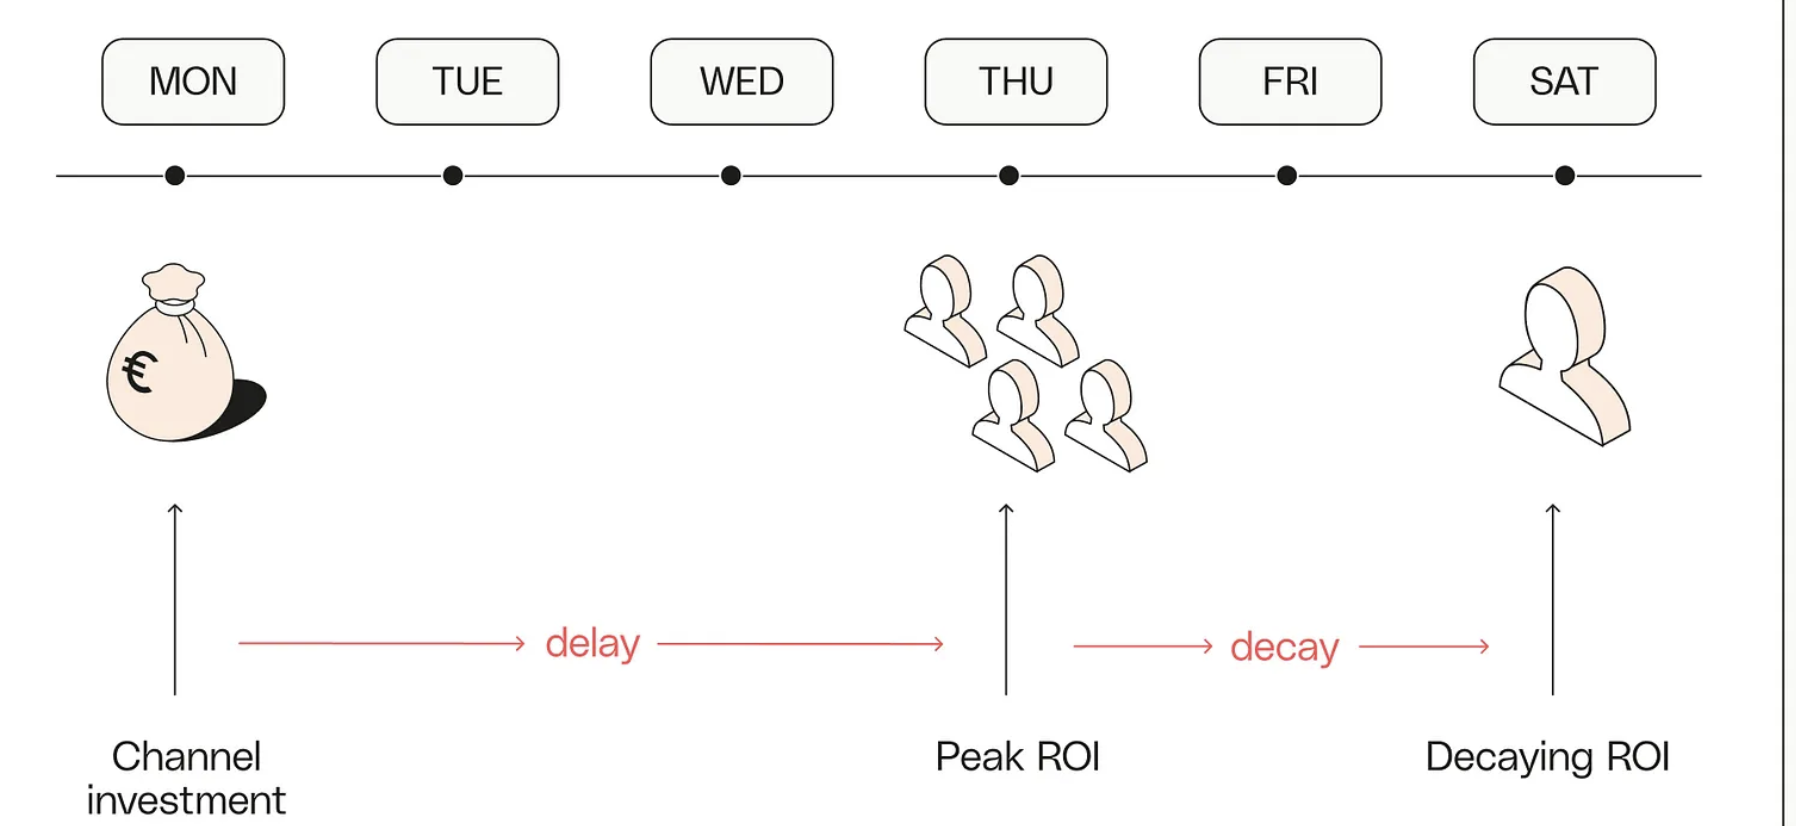



The **lag effect** refers to the delay between a marketing investment (e.g., impressions, clicks, or other engagement metrics) and its measurable impact on the target KPI (e.g., sales, revenue, or conversions). The peak effect on the KPI often does not coincide with the time of the investment but occurs later, depending on the nature of the campaign and audience behavior.

The timing of the peak effect depends on the underlying dynamics captured by adstock functions:

- Immediate Peak: The strongest impact happens immediately, often associated with campaigns designed to drive quick responses or conversions.
- Delayed Peak: The strongest impact occurs after a delay, reflecting the time it takes for the audience to act on the exposure, which could span days, weeks, or months.

These lag effects have been explored through **cross-correlation analysis**, providing insights into how and when investments influence outcomes.

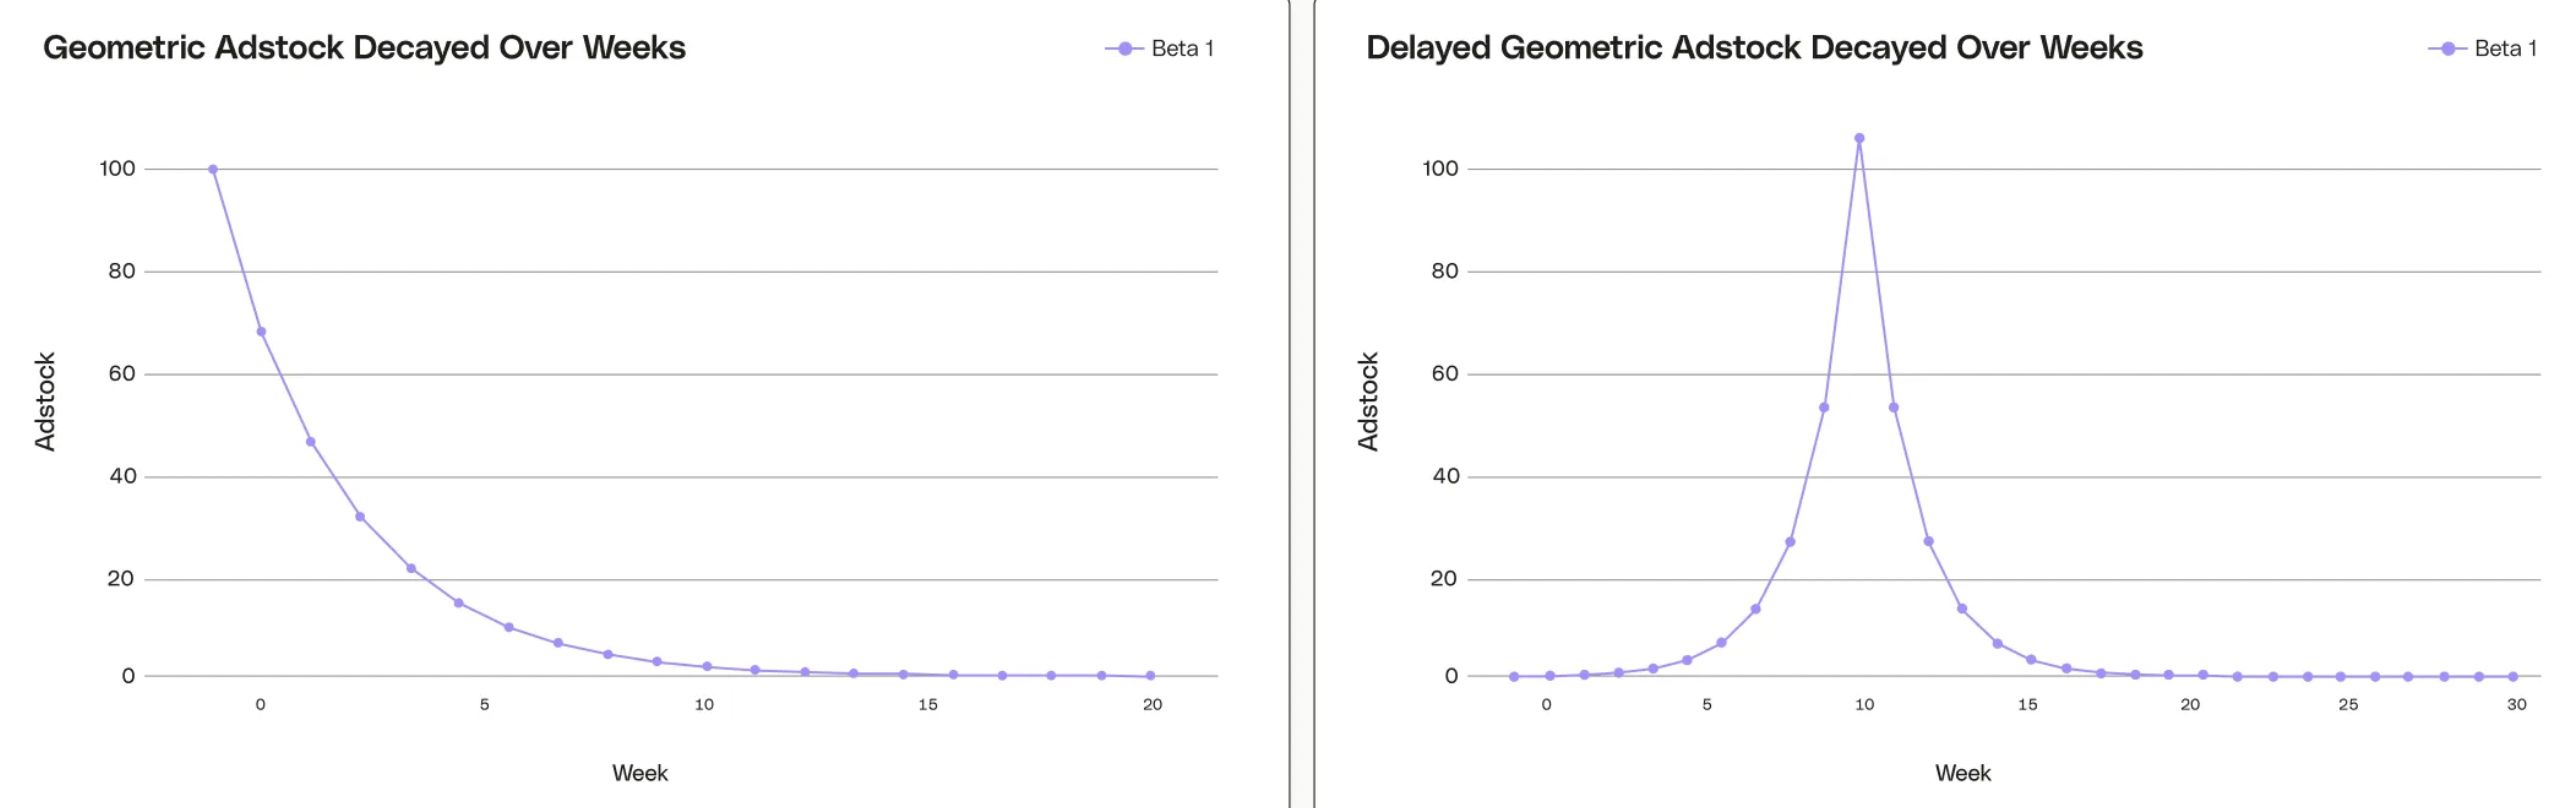

The **time decay effect** (also known as memory or carryover effect) describes how the impact of an ad diminishes over time. While individuals may act on an ad some time after seeing it, their memory of the ad eventually fades, reducing its influence.

Adstock functions model this decay effect and are commonly implemented in two ways:

- Fixed-rate decay: Assumes the memory of an ad diminishes at a constant rate over time.
- Time-varying decay: Assumes the decay rate varies, depending on how long it has been since the ad exposure, providing a more dynamic representation of carryover effects.

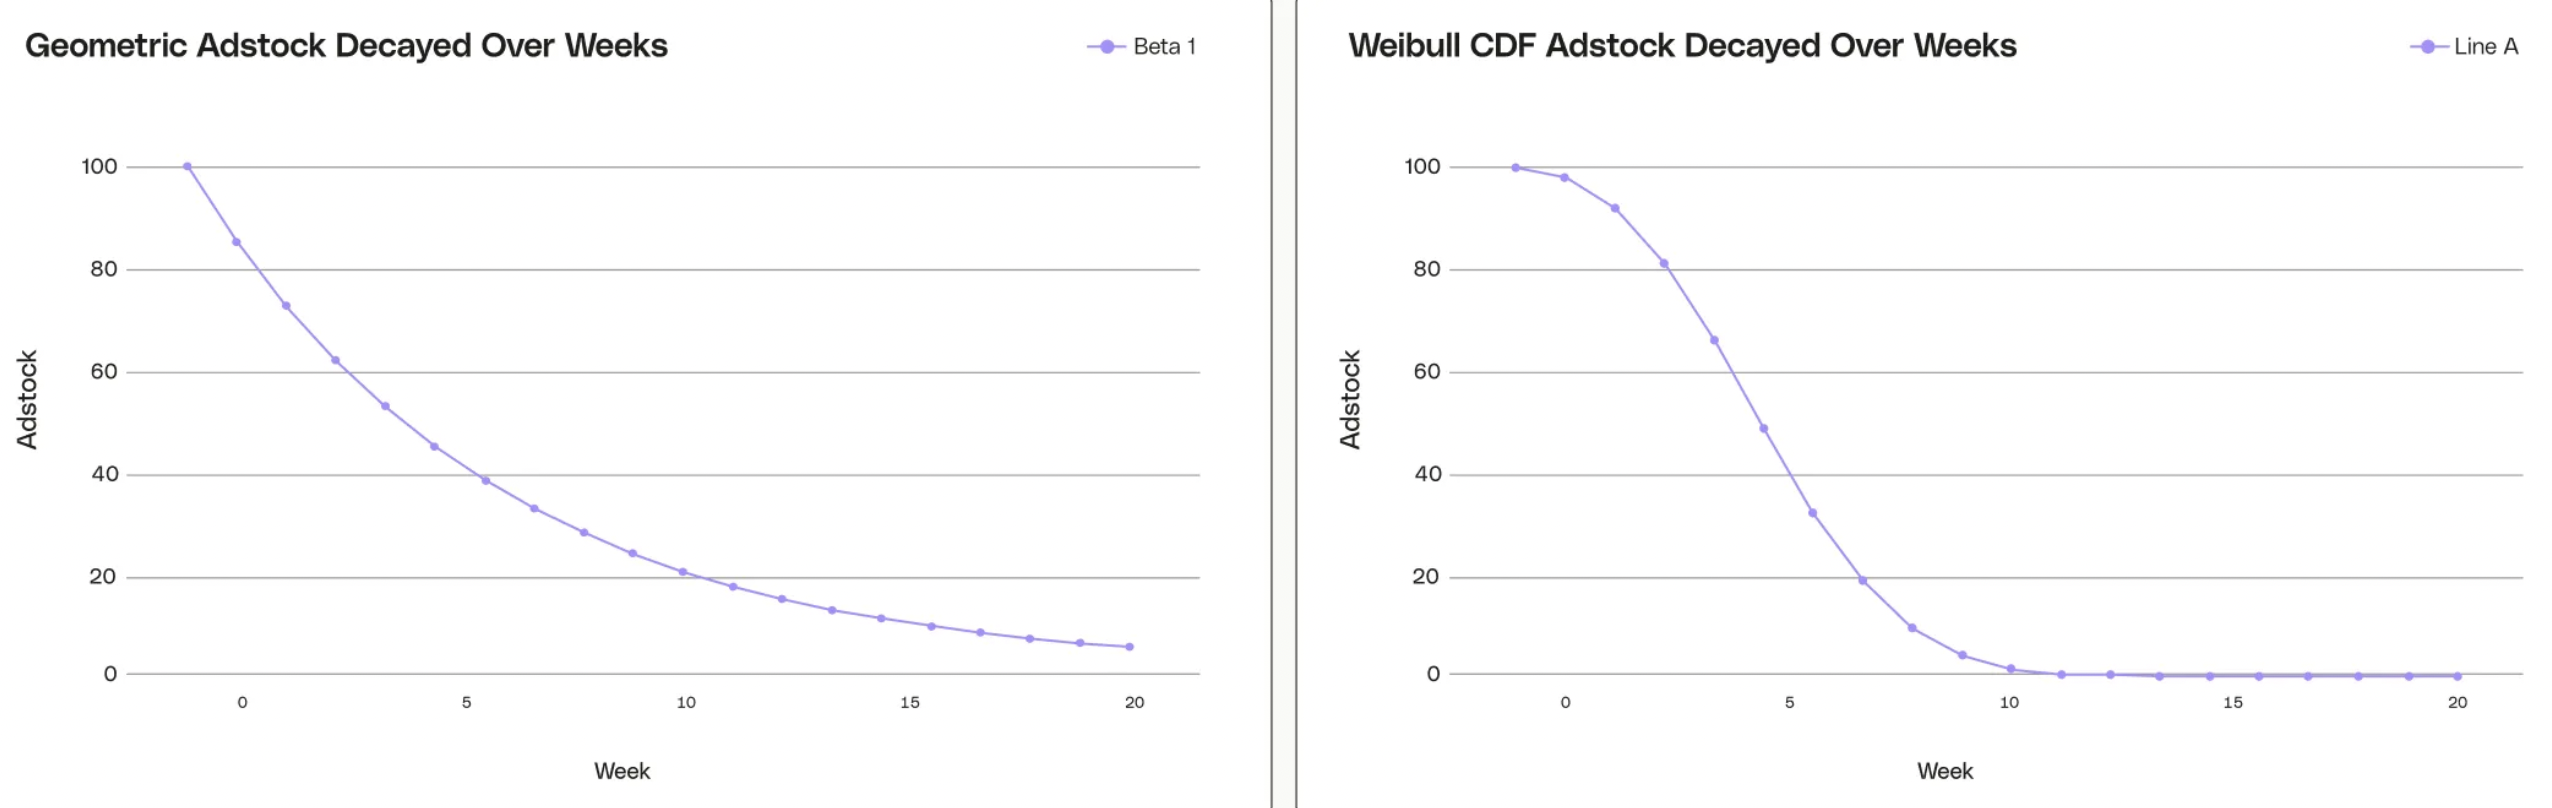

#### Implementing Adstock 🖊

The lag effect has already been addressed through the cross-correlation analysis, which helped us understand the delay between marketing investments and their impact on the target.

Now, we focus on the decay effect, which models how the impact of advertising diminishes over time. To keep things simple, we’ll begin with the most straightforward and interpretable approach:

**The Geometric Adtsock**

$$\text{Adstock}_t = \text{Spend}_t + \lambda \cdot \text{Adstock}_{t-1}$$

The parameter 𝜆 (0<λ<1) represents the decay factor, controlling how quickly advertising effects diminish:

- A higher 𝜆 indicates longer-lasting effects.
- A lower λ suggests shorter-lived impacts.

This decay factor allows us to estimate the half-life (τ), which is the time it takes for the Adstock value to decay to half its initial value.

**Deriving the Half-Life Formula**

Assume there is no new advertising input ($\text{Spend}_t = 0$), meaning the investment is an impulse. The Adstock equation simplifies to:

$$A_{t+1} = \lambda A_t$$

Proceeding recursively:

$$A_{t+2} = \lambda A_{t+1} = \lambda (\lambda A_t) = \lambda^2 A_t$$

Generalizing for 𝑛 periods:

$$A_{t+n} = \lambda^n A_t$$

To find the half-life (𝜏), set $A_{t+n} = \frac{A_t}{2}$:

$$\frac{A_t}{2} = \lambda^n A_t$$

Divide through by $A_t$(assuming $A_t > 0$):

$$\frac{1}{2} = \lambda^n$$

Take the logarithm on both sides:

$$\log\left(\frac{1}{2}\right) = n \log(\lambda)$$

Solve for 𝑛, which represents the half-life (𝜏):

$$\tau = \frac{\log(0.5)}{\log(\lambda)}$$


## Explore the Adstock Transformation 🪄


To capture both the lag effect (delayed impact of investments) and the decay effect (diminishing impact over time), we apply the Adstock transformation to the lagged channels. This transformation enables us to integrate the temporal dynamics of marketing efforts into a single metric for modeling.

In [29]:
def geometric_adstock(investment_series: np.typing.ArrayLike,
                      decay_rate: float) -> np.array:
    if not (0 <= decay_rate < 1):
        raise ValueError("Decay factor must be between 0 and 1.")

    transformed = np.zeros_like(investment_series)
    transformed[0] = investment_series[0]

    for i in range(1, len(investment_series)):
        transformed[i] = investment_series[i] + decay_rate * transformed[i - 1]
    return transformed

In [30]:
decay_rate_widget = widgets.FloatSlider(min=0, max=0.99, step=0.01)
lagged_channels_dropdown = widgets.Dropdown(description='Delayed Channel', options=lagged_channels_names)

def plot_adstock_transformation(channel: str, decay_rate: int):

  sel_df = lagged_df.select(date_col, target, channel).drop_nulls()
  adstock_investment = geometric_adstock(sel_df[channel].to_list(),
                                         decay_rate)

  adstock_channel_name = f"{channel}_adstock"
  adstock_df = sel_df.with_columns(
      pl.Series(name=adstock_channel_name, values=adstock_investment))

  plot_title = f"{target} vs Adstock {channel} Relationship - Decay Rate {np.round(decay_rate, 2)}"
  plot_target_channel_relationship(adstock_df,
                                   col_to_scale=adstock_channel_name,
                                   col_to_corr=adstock_channel_name,
                                   plot_title=plot_title)


In [31]:
interactive_adstock_plot = interactive(plot_adstock_transformation,
                                        channel=lagged_channels_dropdown,
                                        decay_rate=decay_rate_widget
                                      )

display(interactive_adstock_plot)

interactive(children=(Dropdown(description='Delayed Channel', options=('promo_investment_lag0', 'ppc_brand_inv…

**Observations** 🔍

- Promo investment: the geometric Adstock transformation does not improve the relationship for promo investment, which makes sense given its instantaneous nature. Promotions typically drive immediate responses, so a lagged transformation is unnecessary
- Cross-correlation consistency: the results align with the cross-correlation analysis. For instance, the PPC brand channel, characterized by a low decay rate, shows the most immediate and significant relationship with the target. This confirms that channels with quick responses do not benefit from high decay factors.
- High decay rates (λ > ~*0.7*): for high decay rates, the Adstock transformation captures long-lasting effects, resulting in a smoothed curve that retains much of the cumulative investment over time. This smoothing effect amplifies underlying seasonal trends, as the transformation stretches out the influence of past investments, making recurring patterns (such as yearly seasonality) more visible


### Optimal Decay Rate and Half-Life Estimation 🕙

After exploring the effects of the adstock transformation, a useful approach in this exploratory phase to determine the optimal decay rate is to identify the decay rate that maximizes the correlation with the target. However, to ensure a linear relationship with the target, we will impose an upper bound on the decay rate at 0.8.

In [32]:
def find_optimal_correlation_decay_rate(investments_series: np.typing.ArrayLike,
                                        target: np.typing.ArrayLike,
                                        max_decay_rate: float = 0.8) -> list[float]:
    corrs = []
    rates = np.arange(0, max_decay_rate, 0.001)
    rmax = 0
    corrmax = -1

    for r in rates:
        x = geometric_adstock(investments_series, r)
        y = target
        corr = np.corrcoef(x, y)[0][1]
        corrs.append(corr)
        if corr > corrmax:
            rmax = r
            corrmax = corr
    return [rmax, corrmax]


def calculate_half_life(decay_rate: float) -> float:
  return np.round(np.log(0.5) / np.log(decay_rate), 2)



def get_half_life_df(df: pl.DataFrame, col_names: list[str],
                     target: str = target,
                     sort_col: str = date_col) -> pl.DataFrame:

  rates = []
  half_lifes = []
  corrs = []
  ad_corrs = []
  for col in col_names:
    sel_df = df.select(target, col).drop_nulls()
    corr = df.select(pl.corr(target, col)).item()
    corrs.append(corr)
    rate = find_optimal_correlation_decay_rate(sel_df[col].to_list(),
                                               sel_df[target].to_list()
                                               )
    half_life = calculate_half_life(rate[0])
    rates.append(rate[0])
    half_lifes.append(half_life)
    ad_corrs.append(rate[1])

  return (
      pl.DataFrame()
      .with_columns(
          pl.Series(name='Delayed Channel', values=col_names),
          pl.Series(name='Decay Rate', values=rates),
          pl.Series(name='Half Life [Week]', values=half_lifes),
          pl.Series(name='Adstock Corr', values=ad_corrs).round(2),
          pl.Series(name='Corr', values=corrs).round(2),
      )
  )


In [33]:
half_life_df = get_half_life_df(lagged_df, lagged_channels_names)
half_life_df

Delayed Channel,Decay Rate,Half Life [Week],Adstock Corr,Corr
str,f64,f64,f64,f64
"""promo_investment_lag0""",0.032,0.2,0.75,0.75
"""ppc_brand_investment_lag0""",0.547,1.15,0.86,0.85
"""ppc_generic_investment_lag3""",0.799,3.09,0.71,0.65
"""facebook_investment_lag2""",0.799,3.09,0.76,0.64
"""instagram_investment_lag6""",0.748,2.39,0.83,0.76


### Saturation Transformation - Diminishing Returns 📉

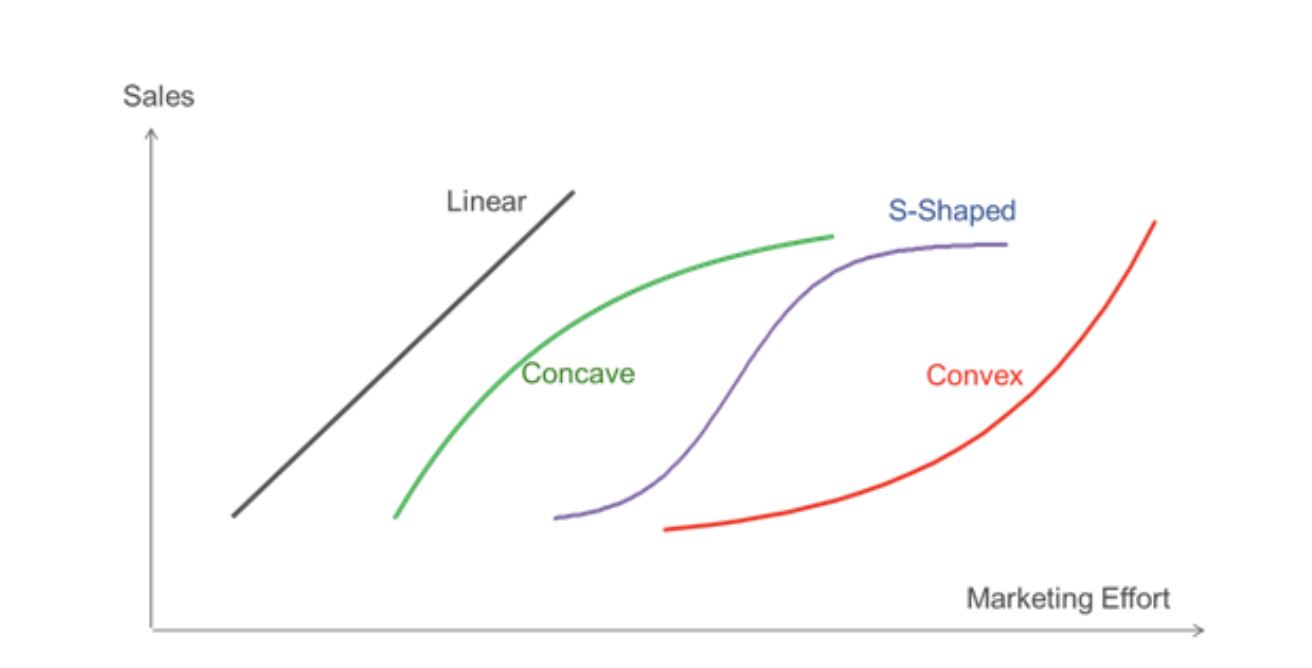


Sales response functions generally fall into four fundamental shapes: linear, concave, convex, and S-shaped. Each shape reflects a unique relationship between marketing mix elements and sales, providing insights into how changes in marketing efforts impact sales performance. Understanding these response shapes is essential for designing effective marketing strategies and allocating resources optimally.
\
\
**Diminishing Returns: Concave Model**

One of the most commonly observed and applied patterns in Marketing Mix Modeling (MMM) is the concave response curve, which represents diminishing returns to scale. As marketing investments increase (e.g., advertising spend, discounts, promotional efforts), the incremental gains in performance (such as sales or customer acquisition) gradually decrease. This reflects real-world market behavior, where excessive marketing saturation leads to a declining marginal impact on the target outcome.
\
\
**Modeling Saturation**

1. Logarithmic Saturation
This transformation models rapid early growth followed by a slowdown in returns. It is particularly useful when marketing efforts show strong initial effects that taper off over time.
$$x_{t}^{\text{transf}} = ln(x_{t} + 1)$$

\

2. Root Transformation (Power Law Saturation)
The root transformation provides more flexibility than the logarithmic function, as the extent of diminishing returns is controlled by an exponent
𝛽. It allows for customizable saturation effects—lower 𝛽 values (e.g., 0.5) create stronger diminishing returns, while higher values (closer to 1) allow for milder effects.
$$x_{t}^{\text{transf}} = x_{t}^{\beta}, \beta \in (0,1]$$

\

3. Logistic Saturation (Sigmoidal Response Curve)
The logistic function captures saturation by modeling slow initial growth, rapid acceleration, and eventual plateauing at higher investment levels. It is suitable for channels where marketing effectiveness grows gradually, peaks, and then plateaus due to market saturation (e.g., TV advertising, where excessive frequency does not increase effectiveness).

$$
x_{t}^{\text{transf}} = \frac{1 - e^{-\beta x_{t}}}{1 + e^{-\beta x_{t}}}, \beta >= 0
$$


[For further info](https://www.ashokcharan.com/Marketing-Analytics/~mx-mmm-sales-response-function.php#gsc.tab=0)

#### Transforming The Promo Investment 🪄

In [34]:
saturation_col = 'promo_investment'


def log_transformation(x: np.ndarray) -> np.ndarray:
    return np.log(x + 1)


def root_transformation(x: np.ndarray, beta: float) -> np.ndarray:
    if not (0 < beta <= 1):
        raise ValueError("Beta must be in the range (0, 1].")
    return x**beta


def logistic_transformation(x: np.ndarray, beta: float) -> np.ndarray:
  x_norm = (x-np.min(x))/(np.max(x)-np.min(x))
  if beta < 0:
    raise ValueError("Beta must be greater than zero")
  return (1 - np.exp(-beta * x_norm)) / (1 + np.exp(-beta * x_norm))


In [35]:
plot_title = f"{target} vs {saturation_col} Relationship"
plot_target_channel_relationship(lagged_df,
                                 col_to_scale=saturation_col,
                                 col_to_corr=saturation_col,
                                 plot_title=plot_title)

In [36]:
saturated_col_name = f"{saturation_col}_transformed"

saturation_df = df.select(date_col, target, saturation_col).sort(date_col)
log_col = log_transformation(saturation_df[saturation_col].to_numpy())
saturation_df = saturation_df.with_columns(
      pl.Series(name=saturated_col_name, values=log_col)
  )

plot_title = f"{target} vs Log {saturation_col} Relationship"
plot_target_channel_relationship(saturation_df,
                                 col_to_scale=saturated_col_name,
                                 col_to_corr=saturated_col_name,
                                 plot_title=plot_title)

In [37]:
logistic_param_widget = widgets.FloatSlider(min=0.01, max=10, step=0.01)

def plot_logistic_transformation_beta_change(beta: float):

  logistic_df = df.select(date_col, target, saturation_col).sort(date_col)
  logistic_col = logistic_transformation(
      logistic_df[saturation_col].to_numpy(),
      beta)
  logistic_df = logistic_df.with_columns(
      pl.Series(name=saturated_col_name, values=logistic_col)
  )

  beta_param = np.round(logistic_param_widget.value, 2)
  plot_title = f"{target} vs Logistic {saturation_col} Relationship - Beta: {beta_param} "
  plot_target_channel_relationship(logistic_df,
                                   col_to_scale=saturated_col_name,
                                   col_to_corr=saturated_col_name,
                                   plot_title=plot_title)

In [38]:
interactive_logistic_plot = interactive(plot_logistic_transformation_beta_change,
                                        beta=logistic_param_widget
                                        )

display(interactive_logistic_plot)

interactive(children=(FloatSlider(value=0.01, description='beta', max=10.0, min=0.01, step=0.01), Output()), _…

In [39]:
root_param_widget = widgets.FloatSlider(min=0.001, max=1, step=0.001)

def plot_root_transformation_beta_change(beta: float):

  root_df = df.select(date_col, target, saturation_col).sort(date_col)
  root_col = root_transformation(
      root_df[saturation_col].to_numpy(),
      beta)
  root_df = root_df.with_columns(
      pl.Series(name=saturated_col_name, values=root_col)
  )

  beta_param = np.round(beta, 3)
  plot_title = f"{target} vs Root {saturation_col} Relationship - Beta: {beta_param} "
  plot_target_channel_relationship(root_df,
                                   col_to_scale=saturated_col_name,
                                   col_to_corr=saturated_col_name,
                                   plot_title=plot_title)

In [40]:
interactive_root_plot = interactive(plot_root_transformation_beta_change,
                                        beta=root_param_widget
                                        )

display(interactive_root_plot)

interactive(children=(FloatSlider(value=0.001, description='beta', max=1.0, min=0.001, step=0.001), Output()),…

**Observations** 🔍

Observing the impact of the transformation on the promotion variable, the root transformation with an exponent of approximately 0.256 appears to be the most suitable. This transformation effectively linearizes the relationship between the promotion spend and the target variable, ensuring a more stable and interpretable contribution in the model.

## It's Model Time! 💃

Let's sum up what we discovered so far 😎

1. The target series exhibits an increasing **trend** and **yearly seasonality**.

2. The relationship between channel investments and the target is non perfectly linear and sensitive to **lag effects**. Moreover this relationship changes according to the meteorological season.

3. While Promo and PPC Brand channels show instantaneous correlations with the target, other channels exhibit delayed effects. By applying the geometric Adstock transformation to lagged channels, we **linearize** the relationship between investments and the target, allowing us to approximate the half-life of investments and determine the optimal decay rate.

4. Promotions, however, do not benefit from the Adstock transformation as their effects are immediate. Instead, they are affected by **saturation**, where the square root transformation proves to be the most effective for modeling diminishing returns.

5. With these insights, we are now ready to fit our first regression model, leveraging the transformations and relationships identified.


**Raw Model Definition**

$$\mathbf{Y(t)} = \alpha + \text{seasonality}_t + \text{trend}_t + \gamma_{1}\text{saturation}(\text{Promo}(t)) + \gamma_{2}\text{adstock}(\text{PPC_brand}(t)) + \gamma_{3}\text{adstock}(\text{lag(PPC_generic}(t))) + \gamma_{4}\text{adstock}(\text{lag(Facebook}(t))) +\gamma_{5}\text{adstock}(\text{lag(Instagram}(t)))$$

\



Let's see every component in detail

**Trend Component**

$kt$

**Seasonal Component**

$\sum_{i=1}^{2} \left[ \alpha_i \sin\left(2\pi \frac{i}{52} t\right) + \beta_i \cos\left(2\pi \frac{i}{52} t\right) \right]$


**Promo component**

$\gamma_{1}\text{Promo}(t)^{0.259}$

**PPC Brand Component**

$\gamma_{2}\text{Adstock}(\text{PPC_brand}(t), \lambda = 0.55)$


**PPC Generic Component**

$\gamma_{3}\text{Adstock}(\text{PPC_generic}(t -3)), \lambda = 0.80)$


**Facebook Component**

$\gamma_{4}\text{Adstock}(\text{Facebook}(t -2), \lambda = 0.80)$


**Instagram Component**

$\gamma_{5}\text{Adstock}(\text{Facebook}(t -6), \lambda = 0.75)$

\




**Explicit Model Definition**

$$
Y(t) = \alpha + kt + \sum_{i=1}^2 \left[ \alpha_i \sin\left(\frac{2 \pi i}{52} t\right) + \beta_i \cos\left(\frac{2 \pi i}{52} t\right) \right] + \gamma_1 \cdot \text{Promo}(t)^{0.259} + \gamma_2 \text{adstock}(\text{PPC_brand}(t), \lambda=0.55) + \gamma_3 \text{adstock}(\text{PPC_generic}(t-3), \lambda=0.80) + \gamma_4  \text{adstock}(\text{Facebook}(t-2), \lambda=0.80) + \gamma_5 \text{adstock}(\text{Instagram}(t-6), \lambda=0.75)
$$

**Building The Dataframe**

We model periodic variations using a linear combination of sine and cosine functions, where each term represents a **harmonic component** of the fundamental annual cycle. This approach captures recurring seasonal patterns by generating sinusoidal cycles that complete one full period over 52 weeks (one year). Specifically, the term $2π(i/52)t$ produces sine and cosine waves with frequencies that are integer multiples of the fundamental annual frequency. Since the base period is 52 weeks, each frequency component corresponds to
$i/52$ cycles per week, or equivalently, $i$ cycles per year.

In [41]:
DAWN_OF_TIME = date(2018, 3, 16)


def build_harmonics(df: pl.DataFrame, period: int, n_harms: int,
                    date_col: str = 'week_start') -> pl.DataFrame:
    if 'time' not in df.columns:
        df = df.with_columns(
            ((pl.col(date_col) - DAWN_OF_TIME).dt.total_days() // 7).alias('time')
        )

    # Add sine and cosine harmonics
    for i in range(1, n_harms + 1):
        df = df.with_columns([
            (np.sin(2 * np.pi * i / period * pl.col('time'))).alias(f'sin_{period}_{i}'),
            (np.cos(2 * np.pi * i / period * pl.col('time'))).alias(f'cos_{period}_{i}')
        ])

    return df

In [42]:
regression_df = lagged_df.clone()
regression_df = regression_df.sort(date_col).drop_nulls()
regression_df = build_harmonics(regression_df, period=52, n_harms=2)
regression_df = regression_df.drop_nulls().sort(date_col)
regression_df.head()

week_start,new_customers,promo_investment,ppc_brand_investment,ppc_generic_investment,facebook_investment,instagram_investment,year,week,promo_investment_lag0,ppc_brand_investment_lag0,ppc_generic_investment_lag3,facebook_investment_lag2,instagram_investment_lag6,time,sin_52_1,cos_52_1,sin_52_2,cos_52_2
date,i64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64
2020-05-18,777,1304.227029,756.818857,1512.071585,297.193399,4593.059512,2020,21,1304.227029,756.818857,2300.295763,999.081772,82.890357,113,0.885456,0.464723,0.822984,-0.568065
2020-05-25,978,3000.504127,69.654279,399.82446,0.0,792.564928,2020,22,3000.504127,69.654279,4268.329032,637.97411,1246.32403,114,0.935016,0.354605,0.663123,-0.748511
2020-06-01,950,4609.816216,357.467625,471.992936,1769.420849,3281.127107,2020,23,4609.816216,357.467625,4219.098648,297.193399,1969.201111,115,0.970942,0.239316,0.464723,-0.885456
2020-06-08,800,3429.065037,425.663469,1181.626485,2353.024023,4510.560793,2020,24,3429.065037,425.663469,1512.071585,0.0,2889.605271,116,0.992709,0.120537,0.239316,-0.970942
2020-06-15,320,6679.522877,530.894558,1962.369223,2351.488377,3760.098884,2020,25,6679.522877,530.894558,399.82446,1769.420849,4303.434984,117,1.0,5.5109e-16,1.1022e-15,-1.0


In [53]:
cos_sin_columns = [col for col in regression_df.columns if 'sin' in col or 'cos' in col]
px.line(regression_df, x='week_start', y=cos_sin_columns, title='Harmonics')

In [43]:
half_life_df

Delayed Channel,Decay Rate,Half Life [Week],Adstock Corr,Corr
str,f64,f64,f64,f64
"""promo_investment_lag0""",0.032,0.2,0.75,0.75
"""ppc_brand_investment_lag0""",0.547,1.15,0.86,0.85
"""ppc_generic_investment_lag3""",0.799,3.09,0.71,0.65
"""facebook_investment_lag2""",0.799,3.09,0.76,0.64
"""instagram_investment_lag6""",0.748,2.39,0.83,0.76


In [44]:
adstock_params = {
    "ppc_brand_investment_lag0": 0.55,
    "ppc_generic_investment_lag3": 0.8,
    "facebook_investment_lag2": 0.8,
    "instagram_investment_lag6": 0.75
}

saturation_param = 0.26
rename_dict = {
    "promo_investment_lag0": "promo_regressor",
    "ppc_brand_investment_lag0": "brand_regressor",
    "ppc_generic_investment_lag3": "generic_regressor",
    "facebook_investment_lag2": "facebook_regressor",
    "instagram_investment_lag6": "instagram_regressor"
}

In [45]:
# Transform Marketing Investments

regression_df = regression_df.with_columns(
    pl.Series(name=rename_dict["promo_investment_lag0"],
              values=root_transformation(regression_df["promo_investment_lag0"].to_numpy(), beta=saturation_param))

    )


for channel, param in adstock_params.items():
  regression_df = regression_df.with_columns(
      pl.Series(name=rename_dict[channel],
                values=geometric_adstock(regression_df[channel].to_numpy(), decay_rate=param))

      )

In [46]:
regressors = ['time',
 'sin_52_1',
 'cos_52_1',
 'sin_52_2',
 'cos_52_2',
 'promo_regressor',
 'brand_regressor',
 'facebook_regressor',
 'instagram_regressor',
 'generic_regressor']

### Fit & Evaluate 🪡

In [54]:
def fit_lr_model(train_df: pl.DataFrame, reg_cols: list[str],
                 target: str = target):
  train_df = train_df.to_pandas()
  train_x, train_y = train_df[reg_cols], train_df[target]
  train_x = sm.add_constant(train_x)
  model = sm.OLS(train_y, train_x)
  fitted_model = model.fit()
  print(fitted_model.summary())
  return fitted_model


def evaluate_model(model, train_df: pl.DataFrame):
  fitted_values = np.clip(model.fittedvalues, 0, None)
  train_df = train_df.to_pandas()
  train_y = train_df[target]
  fig = px.scatter(x = fitted_values, y = train_y)
  max_new_customers = max(train_y)
  fig.add_trace(go.Scatter(x=np.linspace(0, max_new_customers, 50), y=np.linspace(0, max_new_customers, 50), mode='lines', name='markers', line={'color':'black'}))
  fig.update_layout(showlegend=False, title = 'Goodness Of Fit' ,xaxis_title="Fitted", yaxis_title="Actual")
  fig.show()
  fig = px.line(x = list(range(len(train_df))), y = [train_y, fitted_values], title='Compare Fitted & Actual',
                labels={'y': 'New Customers', 'x': 'Time'})
  fig.update_layout(showlegend=False)
  fig.show()
  print(f"MAE: {mean_absolute_error(train_y, fitted_values)}")

In [55]:
model = fit_lr_model(regression_df, regressors)
evaluate_model(model, regression_df)

                            OLS Regression Results                            
Dep. Variable:          new_customers   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     122.0
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           6.64e-68
Time:                        13:12:18   Log-Likelihood:                -1323.6
No. Observations:                 165   AIC:                             2669.
Df Residuals:                     154   BIC:                             2703.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1154.2446    

MAE: 600.8012377926539




**Observations** 🔍

The model seems to work just fine.. but are we overlooking something?

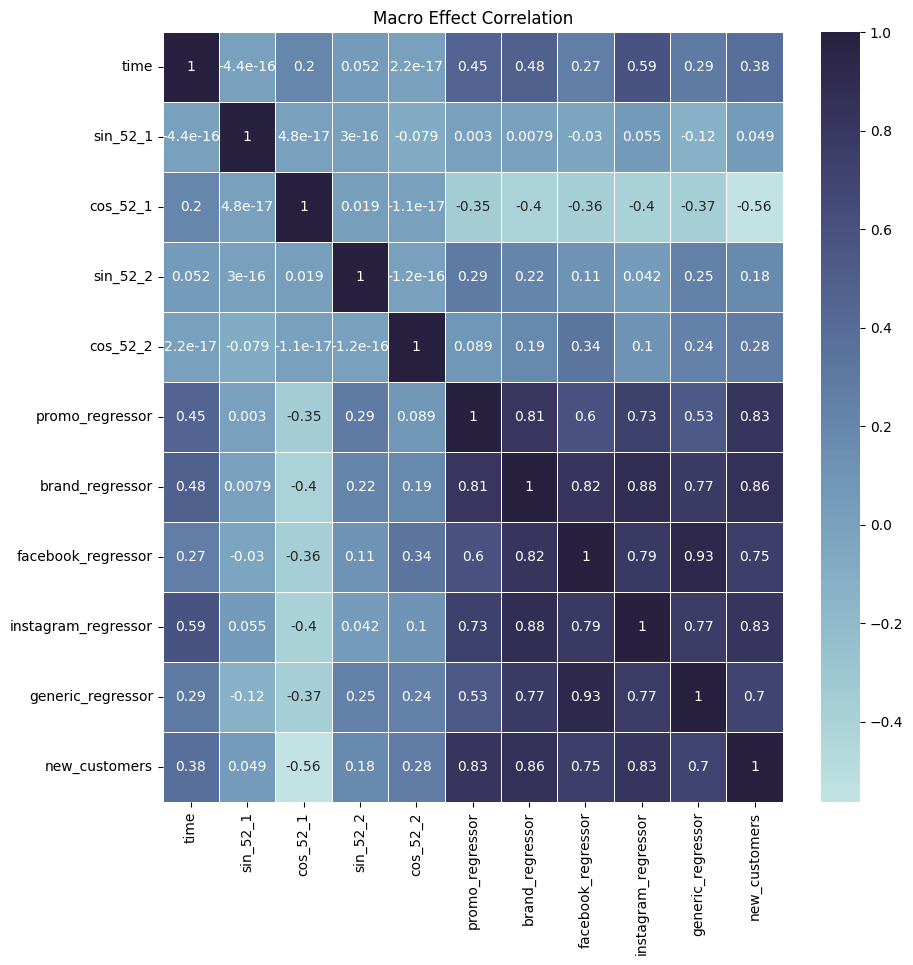

In [49]:
# Collinearity Inspection

plt.figure(figsize=(10, 10))
sns.heatmap(regression_df.to_pandas()[regressors + [target]].corr(), annot=True, cmap= sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), linewidths=0.5)
plt.title('Macro Effect Correlation')
plt.show()

**Observations** 🔍

Collinearity presents a significant challenge. While we must include all marketing channels in our model, our goal is to leverage linear regression's interpretability to assess channel effectiveness and compare their contributions. However, high collinearity undermines this objective by making coefficient estimates unstable and unreliable, ultimately weakening the insights we can derive from the model.

In [50]:
cols_to_keep = ['week_start',
 'new_customers',
 'promo_investment',
 'ppc_brand_investment',
 'ppc_generic_investment',
 'facebook_investment',
 'instagram_investment',
 'year',
 'week',
 'promo_investment_lag0',
 'ppc_brand_investment_lag0',
 'ppc_generic_investment_lag3',
 'facebook_investment_lag2',
 'instagram_investment_lag6',
 'time',
 'sin_52_1',
 'cos_52_1',
 'sin_52_2',
 'cos_52_2']
 #regression_df.select(cols_to_keep).write_csv("/content/mmm_data_for_bayes_regression.csv")